### Dependences

In [1]:
import sys
sys.path.append("../")

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from IPython.display import clear_output

from lib.models.dnCNN import dnCNN
import lib.utils as utils

### Loading experiment data

In [2]:
#set experiment ID
EXP_ID = "dnCNN_y50"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [3]:
model = dnCNN()
model.build((None,120,120,3))
print(model.summary())


Model: "dn_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
sequential (Sequential)      multiple                  37184     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  37184     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  37184     
_________________________________________________________________
sequential_3 (Sequential)    multiple                  37184     
_________________________________________________________________
sequential_4 (Sequential)    multiple                  37184     
_________________________________________________________________
sequential_5 (Sequential)    multiple                  37184

### Loading Dataset

7280it [03:56, 30.75it/s]


Loaded 4680 samples


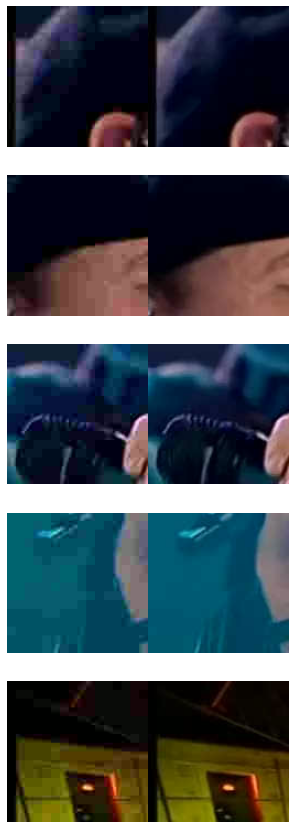

In [4]:
#Loading the training dataset
train_x, train_y = utils.load_dataset("../../dataset/dataset_video_frames2/train",  limit=None, inRoot=True, y_quality=50) 

print("Loaded",train_x.shape[0], "samples")

#check the five firts samples   
utils.show_samples(train_x, train_y, begin=0, end=5)

1708it [00:42, 40.11it/s]


Loaded 1098 samples


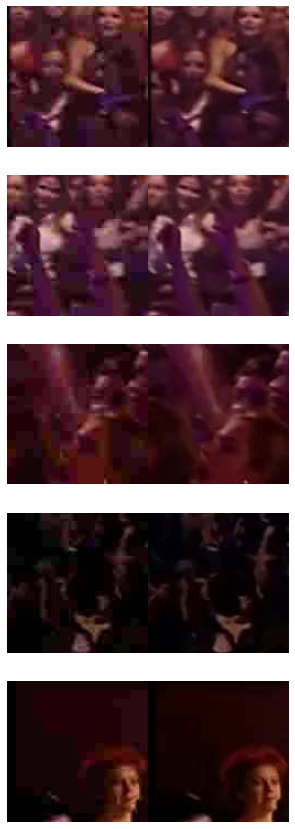

In [5]:
#Loading the training dataset
valid_x, valid_y = utils.load_dataset("../../dataset/dataset_video_frames2/valid",  limit=None, inRoot=True, y_quality=50) #y=50, y=40, y=30

print("Loaded",valid_x.shape[0], "samples")

#check the five firts samples   
utils.show_samples(valid_x, valid_y, begin=0, end=5)

### Dataset shift and normalization

In [6]:
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x, valid_y)

train_x = utils.shift_and_normalize(train_x, SHIFT_VALUE_X, SCALE_VALUE_X)
train_y = utils.shift_and_normalize(train_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

valid_x = utils.shift_and_normalize(valid_x, SHIFT_VALUE_X, SCALE_VALUE_X)
valid_y = utils.shift_and_normalize(valid_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

### Batches split

In [7]:
train_batches = utils.random_mini_batches(train_x, train_y, 8, seed=0)
valid_batches = utils.random_mini_batches(valid_x, valid_y, 8, seed=0)
print("train_batches:", len(train_batches), "valid_batches:", len(valid_batches))

train_batches: 585 valid_batches: 138


### Metrics

In [8]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')

#psnr, ssim and nrmse
valid_custom_metrics = utils.CustomMetric()

### Set Loss and load model weights

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was SSIM=", BEST_VALIDATION)

Loading last model state in epoch 41
Best validation result was SSIM= 0.7975905913408906


### Training

VALIDATION EPOCH 320
JPEG Q10 - JPEG Q50 - PREDICT


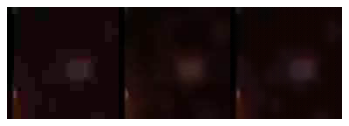

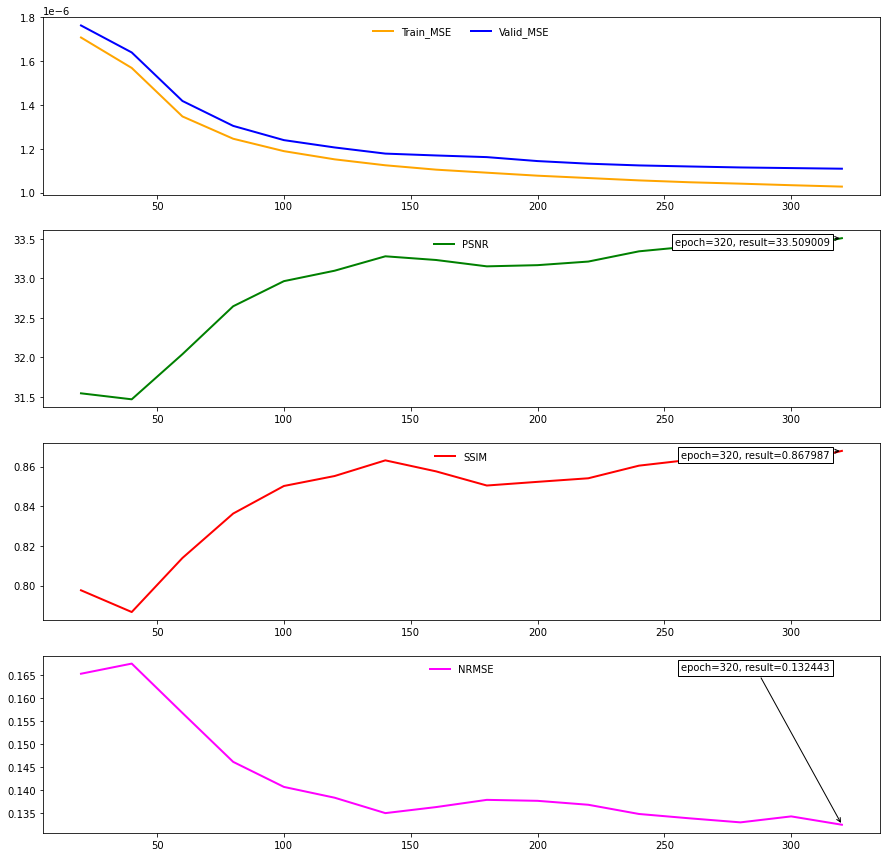

TRAINING EPOCH 321
TRAINING EPOCH 322
TRAINING EPOCH 323
TRAINING EPOCH 324
TRAINING EPOCH 325
TRAINING EPOCH 326
TRAINING EPOCH 327
TRAINING EPOCH 328
TRAINING EPOCH 329
TRAINING EPOCH 330
TRAINING EPOCH 331
TRAINING EPOCH 332
TRAINING EPOCH 333
TRAINING EPOCH 334
TRAINING EPOCH 335


In [ ]:
@tf.function
def train_step(image_x, image_y):
    with tf.GradientTape() as tape:
        predictions = model(image_x)
        loss = loss_object(image_y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

MAX_EPOCHS = 401
EVAL_STEP = 20

for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    for batch in train_batches:
        (batch_x, batch_y) = batch
        train_step(batch_x, batch_y)
    
    #VALIDATION
    if epoch%EVAL_STEP == 0 and epoch > 0:
        #tf.keras.backend.set_learning_phase(0)
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
        for index, batch in enumerate(valid_batches):
            (batch_x, batch_y) = batch
            predictions = model(batch_x)
            valid_mse(batch_y, predictions)
            
            # convert back to original pattern
            batch_x = utils.inv_shift_and_normalize(batch_x.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
            batch_y = utils.inv_shift_and_normalize(batch_y.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            predictions = utils.inv_shift_and_normalize(predictions.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            
            #convert from frequency to pixel-rgb domain
            batch_x, batch_y, predictions = utils.convert_batch_dct2rgb(batch_x, batch_y, predictions)
            
            #feed the metric evaluator
            valid_custom_metrics.feed(batch_y, predictions)
            
            #just show the first example of batch-0
            if index == 0:
                print("JPEG Q10 - JPEG Q50 - PREDICT")
                utils.preview_sample(batch_x[0], batch_y[0], predictions[0])
        
        #get metric results
        psnr, ssim, nrmse = valid_custom_metrics.result()
        valid_mse_result = valid_mse.result().numpy()
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=valid_mse_result, psnr=psnr, ssim=ssim, nrmse=nrmse)
        utils.draw_chart()
        
        #saving best validation model
        if ssim > BEST_VALIDATION:
            BEST_VALIDATION = ssim
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()
    valid_mse.reset_states()
    valid_custom_metrics.reset_states()


### Usage

In [ ]:
#load the model with best SSIM
model.load_weights(utils.get_exp_folder_best_valid())


for img_index in range(0, valid_x.shape[0]):
    img_x = valid_x[img_index:(img_index+1)]
    img_y = valid_y[img_index:(img_index+1)]
    prediction = model(img_x)

    img_x = utils.inv_shift_and_normalize(img_x.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
    img_y = utils.inv_shift_and_normalize(img_y.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
    prediction = utils.inv_shift_and_normalize(prediction.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)

    #convert from frequency to pixel-rgb domain
    img_x, img_y, prediction = utils.convert_batch_dct2rgb(img_x, img_y, prediction)
    print("JPEG Q10 - JPEG Q50 - PREDICT")
    utils.preview_sample(img_x[0], img_y[0], prediction[0])
    plt.pause(0.1)


### test

In [ ]:
#Loading the training dataset
test_x, test_y = utils.load_dataset("../../dataset/dataset_video_frames2/test",  limit=None, inRoot=True)

print("Loaded",test_x.shape[0], "samples")

#check the five firts samples   
utils.show_samples(test_x, test_y, begin=0, end=5)

test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

test_batches = utils.random_mini_batches(test_x, test_y, 8, seed=0)

for index, batch in enumerate(test_batches):
    (batch_x, batch_y) = batch
    predictions = model(batch_x)

    # convert back to original pattern
    batch_x = utils.inv_shift_and_normalize(batch_x.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
    batch_y = utils.inv_shift_and_normalize(batch_y.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
    predictions = utils.inv_shift_and_normalize(predictions.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            
    #convert from frequency to pixel-rgb domain
    batch_x, batch_y, predictions = utils.convert_batch_dct2rgb(batch_x, batch_y, predictions)
            
    #feed the metric evaluator
    valid_custom_metrics.feed(batch_y, predictions)

#get metric results
psnr, ssim, nrmse = valid_custom_metrics.result()
print("Results for test set")
print("SSIM", ssim)
print("PSNR", psnr)
print("NRMSE", nrmse)

## test with full frame

In [ ]:
import lib.jpeg as jpg
import cv2

frame_path = "../../dataset/dataset_video_frames/full_frame_test/2.jpg"

qtable_luma_50, qtable_chroma_50 = jpg.generate_qtables(quality_factor=50)
qtable_luma_10, qtable_chroma_10 = jpg.generate_qtables(quality_factor=10)

frame = utils.open_image(frame_path)

qtdy_patches = (frame.shape[0]/120)*(frame.shape[1]/120)

frame_q10 = np.zeros(frame.shape, dtype=np.uint8)
frame_q50 = np.zeros(frame.shape, dtype=np.uint8)
frame_pred = np.zeros(frame.shape, dtype=np.uint8)

print(qtdy_patches)

for i in range(0, frame.shape[0],120):
    for j in range(0, frame.shape[1],120):
        pos_x = (i*120)
        pos_y = (j*120)
        patch = frame[i:(i+120),j:(j+120),:]
        dct_q10 = jpg.encode_image(patch, qtable_luma_10, qtable_chroma_10)
        dct_q10 = np.expand_dims(dct_q10, axis=0)
        dct_q10 = utils.shift_and_normalize(dct_q10, SHIFT_VALUE_X, SCALE_VALUE_X)
        dct_q50 = jpg.encode_image(patch, qtable_luma_50, qtable_chroma_50)
        dct_q50 = np.expand_dims(dct_q50, axis=0)
        dct_q50 = utils.shift_and_normalize(dct_q50, SHIFT_VALUE_Y, SCALE_VALUE_Y)
        prediction = model(dct_q10)
        
        # convert back to original pattern
        dct_q10 = utils.inv_shift_and_normalize(dct_q10.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
        dct_q50 = utils.inv_shift_and_normalize(dct_q50.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
        prediction = utils.inv_shift_and_normalize(prediction.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            
        #convert from frequency to pixel-rgb domain
        img_q10, img_q50, prediction = utils.convert_batch_dct2rgb(dct_q10, dct_q50, prediction)
        
        frame_q10[i:(i+120),j:(j+120),:] = img_q10
        frame_q50[i:(i+120),j:(j+120),:] = img_q50
        frame_pred[i:(i+120),j:(j+120),:] = prediction
        
        utils.preview_sample(img_q10[0], img_q50[0], prediction[0])
        
        plt.pause(0.1)


cv2.imwrite("frame_q10.jpg", cv2.cvtColor(frame_q10, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 100])
cv2.imwrite("frame_q50.jpg", cv2.cvtColor(frame_q50, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 100])   
cv2.imwrite("frame_pred.jpg", cv2.cvtColor(frame_pred, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 100])   


       
